# Example notebook to demonstrate the main workflow of the manuscript for one example endpoint

This notebook is part of the supporting information to the manuscript entitled "Assessing the Calibration in Toxicological in Vitro Models with Conformal Prediction". The notebook was developed by Andrea Morger in the 
In Silico Toxicology and Structural Biology Group of Prof. Dr. Andrea Volkamer at the Charité Universitätsmedizin 
Berlin, in collaboration with Fredrik Svensson, Staffan Arvidsson McShane, Niharika Gauraha, Ulf Norinder and Ola Spjuth. It was last updated in December 2020.

## Content

This notebooks demonstrates the main workflow to obtain the results for the manuscript on "Assessing the Calibration in Toxicological in Vitro Models with Conformal Prediction" for an example endpoint.
It can be used to train aggregated conformal predictors on the Tox21Train datasets. The predictions of Tox21Score can be compared in different experiments with and without updated calibration sets as well as with updating the complete training set. The notebook may be adapted to use the code for different datasets if a different endpoint is selected in `input cell 6`.

For a general introduction on conformal prediction (CP) and calibration plots we refer to the manuscript.

### Table of contents
1. [Preparation](#preparation) <br>
    1.1. [Import libraries and modules](#import-libraries-and-modules)<br>
    1.2. [Define paths and parameters](#define-paths-parameters)<br>
2. [Conformal prediction experiments](#cp-experiments)<br>
    2.1. [Load datasets](#load-data)<br>
    2.2. [Using different calibration sets](#different-cal-sets)<br>
    2.3. [Using updated training set](#updated-train-set)<br>
3. [Evaluate conformal predictions](#evaluate-cp)<br>
    3.1. [Calibration and efficiency plots](#cal-plots)<br>
    3.2. [Root-mean-square deviations from the diagonal (rmsd)](#rmsd)<br>

## 1. Preparation <a id='preparation'></a>

### 1.1. Import libraries and modules <a id='import-libraries-and-modules'></a>

In [1]:
import os
import numpy as np
import json
from pathlib import Path

In [2]:
import pandas as pd
from sklearn.svm import SVC
from nonconformist.nc import NcFactory, MarginErrFunc
import matplotlib.pyplot as plt

In [3]:
from cptox21 import (
    define_path, load_signatures_files, StratifiedRatioSampler,CrossValidationSampler,
    KnownIndicesSampler, InductiveConformalPredictor,
    AggregatedConformalPredictor, CPTox21AggregatedConformalPredictor, 
    CPTox21CrossValidator, CPTox21TrainUpdateCrossValidator, 
    calculate_rmsd_from_df, calculate_rmsd_pos_from_df
)

In [4]:
import warnings
warnings.simplefilter("ignore")

### 1.2. Define paths and parameters <a id='define-paths-parameters'></a>

In [5]:
HERE = Path(_dh[-1])
DATA = HERE / "../data"

In [6]:
data_signatures_path = DATA / "data_signatures/"

In [7]:
endpoint = "NR_ER"  # Example endpoint "estrogen receptor" (a nuclear receptor). 
# The `endpoint` parameter may be changed to any of the other Tox21 endpoints 
# (i.e. 'SR_ATAD5', 'NR_ER', 'NR_AR', 'SR_HSE', 'SR_MMP', 'SR_p53', 'NR_Aromatase',
# 'SR_ARE', 'NR_AR_LBD', 'NR_AhR', 'NR_ER_LBD', 'NR_PPAR_gamma')

In [8]:
# Number of loops used in ACP
n_folds_acp = 10

In [9]:
set_random_state = 42  # Set the random seed for deterministic results

## 2. Conformal prediction experiments <a id='cp-experiments'></a>

Note that for programmatic reasons, the conformal prediction experiments are calculated in a different order, not following the story in the manuscript. However, in [Section 3. Evaluate conformal predictions](#evaluate-cp), the order from the manuscript is preserved to explain the results.

To perform the conformal prediction experiments, we need an `AggregatedConformalPredictor` object, which consolidates all the information needed to train an aggregated conformal prediction with a given number of loops (`n_folds_acp`) and a `CrossValidator` objects to handle the splits and folds of a crossvalidation. The two classes are adapted for the different parts (update calibration set and update training set) as shown below.

### 2.1. Load datasets <a id='load-data'></a>
Per endpoint, three datasets are loaded (Tox21Train, Tox21Test, Tox21Score, see manuscript for more explanation) which consist of the precalculated signature descriptors and the activity labels for the corresponding endpoint.

In [10]:
dataset_names = ["train", "test", "score"]  # Tox21 dataset_names
train_path = os.path.join(
        data_signatures_path, f"data_signatures_{endpoint}_{dataset_names[0]}.csr"
    )
test_path = os.path.join(
        data_signatures_path, f"data_signatures_{endpoint}_{dataset_names[1]}.csr"
    )
score_path = os.path.join(
        data_signatures_path, f"data_signatures_{endpoint}_{dataset_names[2]}.csr"
    )

X_train, y_train, X_test, y_test, X_score, y_score = load_signatures_files(train_path, test_path, score_path)

# Comment below code for final run (Uncomment to shorten calculation time for test runs)
# X_train = X_train[:500]
# y_train = y_train[:500]

#### Compare size of datasets
To interpret and assess the results, it might be useful to know, how many data points we actually have per dataset, and how balanced they are.

In [11]:
datasets_size_dict = {"name": dataset_names, "actives": [], "inactives": []}

for dataset, labels in zip(dataset_names, [y_train, y_test, y_score]):
    datasets_size_dict["actives"].append(len(labels[labels==1]))
    datasets_size_dict["inactives"].append(len(labels[labels==0]))

pd.DataFrame.from_dict(datasets_size_dict)

,name,actives,inactives
0,train,132,368
1,test,27,231
2,score,49,441


### 2.2. Using different calibration sets <a id='different-cal-sets'></a>

With the `CPTox21AggregatedConformalPredictor` class, an aggregated conformal predictor can be trained and calibrated with three different calibration sets: The original calibration set split from Tox21train, the more recent update set Tox21test, and the random stratified split (implying the same distribution as the prediction set) from Tox21score.

#### Build Inductive Conformal Prediction classifier (ICP)

In [12]:
clf = SVC(
    kernel='rbf', C=50, gamma=0.002, probability=True, random_state=set_random_state
)  # ML classifier
error_function = MarginErrFunc()  # Error function
normaliser_model = None  # Normaliser model
nc = NcFactory.create_nc(clf, err_func=error_function)  # Nonconformity scorer
icp = InductiveConformalPredictor(
    nc_function=nc, condition=(lambda instance: instance[1])
)  # Mondrian as (default) condition)

#### Build Aggregated Conformal Predictor (ACP) for main framework (using different calibration sets)

In [13]:
acp = CPTox21AggregatedConformalPredictor(
    predictor=icp, sampler=StratifiedRatioSampler(n_folds=n_folds_acp, random_state=set_random_state), aggregation_func=np.median
)

#### Define crossvalidator, with which a crossvalidation can be performed for all acp experiments except for train_update

In [14]:
cross_validator = CPTox21CrossValidator(
    acp, cv_splitter=CrossValidationSampler(random_state=set_random_state), score_splitter=StratifiedRatioSampler(test_ratio=0.5, random_state=set_random_state)
)

#### Crossvalidate

In [15]:
cross_validation_dfs = cross_validator.cross_validate(
    steps=10,  # Number of steps (significance level) for evaluating conformal predictions
    endpoint=endpoint,
    X_train=X_train,
    y_train=y_train,
    X_update=X_test,
    y_update=y_test,
    X_score=X_score,
    y_score=y_score,
)

## 2.3. Using updated training set <a id='updated-train-set'></a>

With the updated training set, new machine learning models are trained. This is can be done with the `train_update_acp` class. The crossvalidation splits from the [2.2. Using different calibration sets](#different-cal-sets) part were saved and can be accessed and used here.

#### Get splits from crossvalidator, so that exactly the same splits can be used for train_update

In [16]:
train_index, test_index = cross_validator.train_indices, cross_validator.test_indices

known_indices_sampler = KnownIndicesSampler(known_train=train_index, known_test=test_index)

#### Define ACP for train_update
Difference to CPTox21AggregatedConformalPredictor: As we do not further update the calibration set for this experiment, we use the `train_update_acp` class.

In [17]:
train_update_acp = AggregatedConformalPredictor(
    predictor=icp, sampler=StratifiedRatioSampler(n_folds=n_folds_acp, random_state=set_random_state), aggregation_func=np.median
)

#### Define train_update crossvalidator using same splits as before and crossvalidate

In [18]:
train_update_cross_validator = CPTox21TrainUpdateCrossValidator(
    train_update_acp, cv_splitter=known_indices_sampler
)

train_update_cross_validation_dfs = train_update_cross_validator.cross_validate(
    steps=10,  # Number of steps (significance level) for evaluating conformal predictions
    endpoint=endpoint,
    X_train=X_train,
    y_train=y_train,
    X_update=X_test,
    y_update=y_test,
    X_score=X_score,
    y_score=y_score,
)

## 3. Evaluate conformal predictions <a id='evaluate-cp'></a>

### 3.1. Calibration and efficiency plots <a id='cal-plots'></a>

In a calibration plot, the observed error rate for a batch of predictions is plotted against the expected error rate (diagonal line). For complementary tracing of the informational efficiency, we also plot the efficiency, defined as the ratio of single class predictions. The plots are, thus, called `calibration and efficiency plots` (CEPs). The firm lines in the plot are the mean values of a five-fold cross-validation, the shaded areas represent the standard deviation.

Calibration plots are useful to assess the calibration of conformal prediction models and to analyse the impact of improvement strategies on the calibration (see below).

In [19]:
plots = {}

##### Cross-validation
As proof-of-concept, let's look at the CEP of the cross-validation. Given the random stratified splitting and sufficient data, the expected error rate should follow the diagonal line.

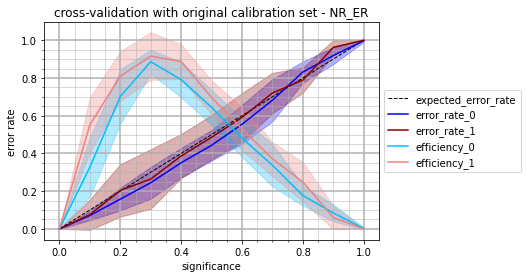

In [20]:
plots["cv"] = cross_validator.calibration_plot( 
    averaged_evaluation_df=cross_validator.averaged_evaluation_df_cv,
    endpoint=endpoint,
    title_name="cross-validation with original calibration set"
)

##### Predict score and test set using the aggregated conformal predictor with the 'original' calibration set
If the training set and the predicted data are drawn from the same distribution, and if they are available in sufficient amount, the error rates should follow the diagonal line. Any deviations suggest deviations from the CP exchangeability assumption (or a too small data size). 

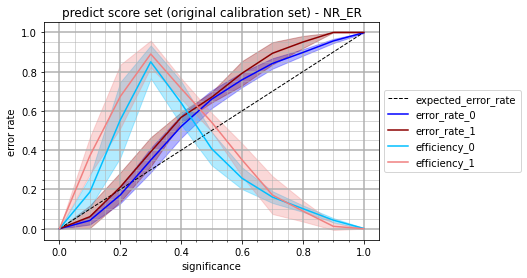

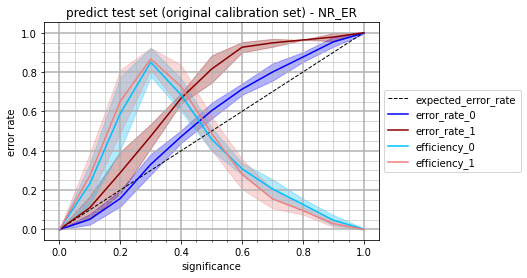

In [30]:
plots["pred_score"] = cross_validator.calibration_plot(
    averaged_evaluation_df=cross_validator.averaged_evaluation_df_pred_score,
    endpoint=endpoint, 
    title_name="predict score set (original calibration set)"
)

plots["pred_test"] = cross_validator.calibration_plot(
    averaged_evaluation_df=cross_validator.averaged_evaluation_df_pred_test,
    endpoint=endpoint, 
    title_name="predict test set (original calibration set)"
)

##### Update (increase) the training set with more recent data
Probably the most intuitive way to improve the validity of the predictions will be to update the training set with more recent data. If "old and new" data are available, they can be combined to train a more up-to-date model. The following plots show the cross-validation of this model as well as the prediction of score data. 

For the prediction of the score data, we, usually (for most endpoints), do not see a big difference to the above CEP, since the number of recent compounds is almost negligible compared to the number of original training compounds. On the other hand, the more recent data would not be enough for training a model on them alone.

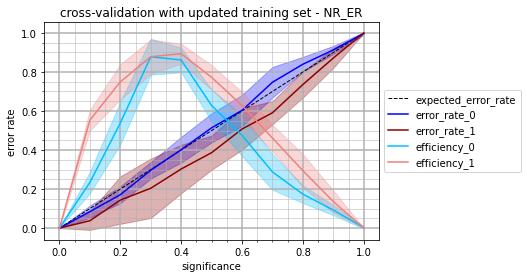

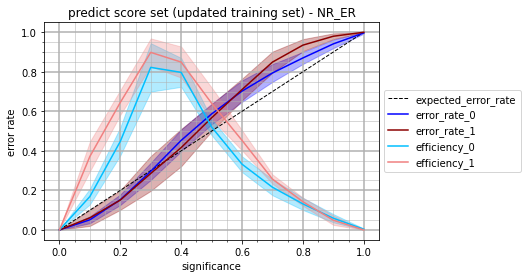

In [31]:
plots["train_update_cv"] = train_update_cross_validator.calibration_plot(
    averaged_evaluation_df=train_update_cross_validator.averaged_evaluation_df_cv,
    endpoint=endpoint, 
    title_name="cross-validation with updated training set"
)

plots["train_update_pred_score"] = train_update_cross_validator.calibration_plot(
    averaged_evaluation_df=train_update_cross_validator.averaged_evaluation_df_pred_score,
    endpoint=endpoint, 
    title_name="predict score set (updated training set)"
)

##### Update (exchange) the calibration set with a more recent dataset
If exchangeability between the datasets cannot be assumed, a proposed strategy to improve the applicability of the model, is to update the calibration set with more recent data.
Based on the chronogical release of the Tox21 datasets, we assume that Tox21test is more similar to Tox21 score than Tox21 train. Thus Tox21test is used to update the calibration set.

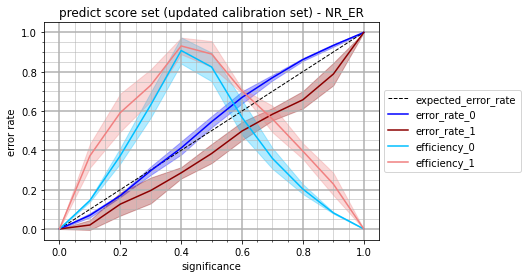

In [32]:
plots["cal_update"] = cross_validator.calibration_plot(
    averaged_evaluation_df=cross_validator.averaged_evaluation_df_cal_update,
    endpoint=endpoint, 
    title_name="predict score set (updated calibration set)"
)

##### Update (exchange) the calibration set with data, which are inherently exchangeable
With the above updating experiment, we made an assumption about the similarity of the datasets. This assumption was not true for all datasets. Thus, a more suitable experiment would be to update the calibration set with one part (50%) of the score set and to predict the other part of the score set. This gives us the certainty that the calibration and the prediction set are drawn from the same distribution. Note, that this might be more suitable as a proof of concept, on the other hand it does not represent a real-life scenario. Furthermore, we might see a larger standard deviation in the error rate, as we predict fewer data points.

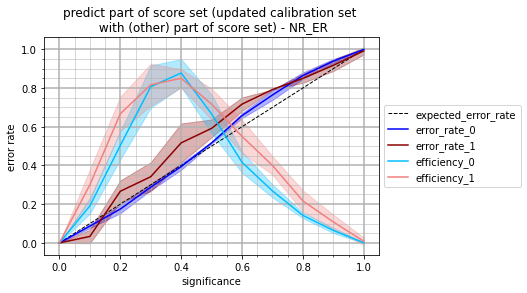

In [33]:
plots["cal_update2"] = cross_validator.calibration_plot(
    averaged_evaluation_df=cross_validator.averaged_evaluation_df_cal_update2,
    endpoint=endpoint, 
    title_name="predict part of score set (updated calibration set \n with (other) part of score set)"
)

### 3.2.  Root-mean-square deviations from the diagonal (rmsd) <a id='rmsd'></a>

To have a value to compare the calibration plots (validity) over all experiments, we calculate the rmsd of the observed error rate to the expected error rate (for 10 significance levels). If we accept overconservative validity, we can also calculate rmsd<sub>pos</sub>, only considering the deviation where the observed error rate is higher than the expected error rate.

#### Collect data (evaluation dfs) from the cross-validators

In [34]:
evaluation_dfs = {}

for strategy in ["cv", "pred_score", "cal_update", "cal_update2"]:
    evaluation_dfs[strategy] = getattr(
        cross_validator, f"averaged_evaluation_df_{strategy}"
    )
for strategy in ["cv", "pred_score"]:
    evaluation_dfs[f"{strategy}_train_update"] = getattr(
        train_update_cross_validator, f"averaged_evaluation_df_{strategy}"
    )                    

#### Calculate rmsd's

In [35]:
rmsds = {}
rmsds_pos = {}
for k, v in evaluation_dfs.items():

    rmsd = calculate_rmsd_from_df(v)
    rmsds[k] = rmsd
    
    rmsd_pos = calculate_rmsd_pos_from_df(v)
    rmsds_pos[k] = rmsd_pos
rmsds

{'cv': 0.031,
 'pred_score': 0.1,
 'cal_update': 0.032,
 'cal_update2': 0.037,
 'cv_train_update': 0.02,
 'pred_score_train_update': 0.062}

#### Scatter plot
To visualise the rmsds over all strategies, a scatter plot can be used

In [36]:
def plot_rmsds(rmsds, strategies, endpoint=endpoint):
    plt.clf()
    fig = plt.figure(figsize=(10,5))
    
    plt.scatter(strategies, [rmsds[s] for s in strategies], marker='_', s=500)
    plt.xticks(rotation='vertical')
    plt.title(f"rmsds for different CP set-ups - {endpoint} endpoint")    

In [37]:
strategies = rmsds.keys()

<Figure size 432x288 with 0 Axes>

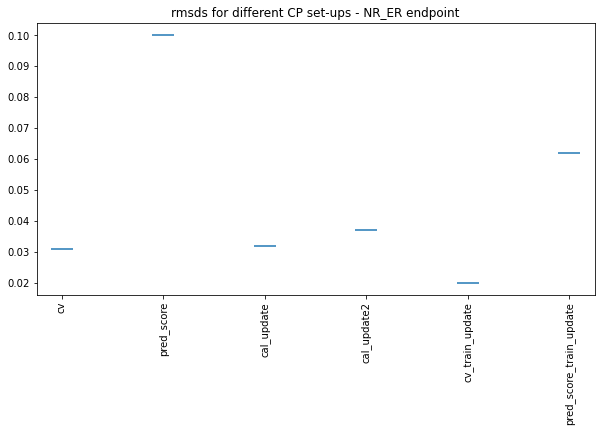

In [38]:
plot_rmsds(rmsds, strategies)

<Figure size 432x288 with 0 Axes>

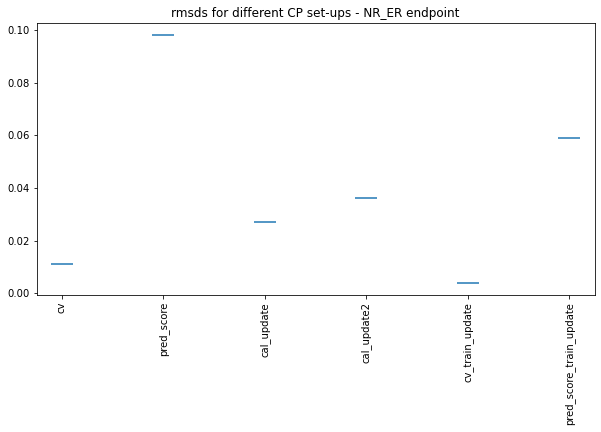

In [39]:
plot_rmsds(rmsds_pos, strategies)